###### Using PyTorch

In [21]:
%config Completer.use_jedi=False
%matplotlib inline

In [22]:
import time
import copy
import glob
import random

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split



In [23]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

In [24]:
train_normal = glob.glob("D:/DataSets/X ray Covid/chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("D:/DataSets/X ray Covid/chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("D:/DataSets/X ray Covid/chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("D:/DataSets/X ray Covid/chest_xray/test/PNEUMONIA/*")

In [25]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [26]:
# Labelling nornal -> 0  , pneumonia -> 1 
train_labels =  [0] * len(train_normal) + [1]* len(train_pneumonia)
test_labels =  [0] * len(test_normal) + [1]* len(test_pneumonia)

In [27]:
print(len(train_paths) , len(train_paths))
print(len(test_paths) , len(test_paths))

5216 5216
624 624


In [28]:
len(train_paths)

5216

In [29]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels,
                                                                        stratify= train_labels)

In [30]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)
    
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = plt.subplot(1 ,2 ,1)
    ax1.imshow(Image.open(path_random_normal).convert("LA") )
    ax1.set_title("Normal X-ray")
    
    ax2 = plt.subplot(1 ,2 ,2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA") )
    ax2.set_title("Abnormal X-ray")
    

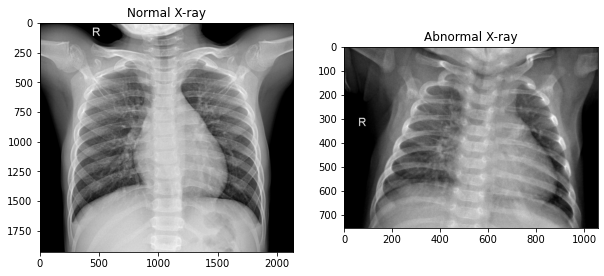

In [31]:
show_random_images()

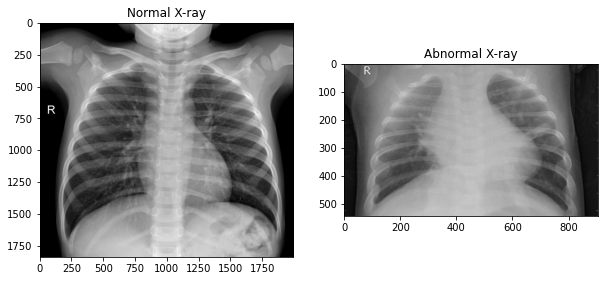

In [32]:
show_random_images()

In [13]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[index] 
        label = torch.tensor([label])
        
        return image ,label

In [14]:
resnet = resnet18() 
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
train_dataset = XrayDataset(train_paths, train_labels)

In [16]:
class PneumoniaNet(nn.Module):
    def __init__(self, pretrained= True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained =pretrained)
        self.fc = nn.Linear(in_features =512, out_features=1)
        
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bnl(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        
        x = x.view(x.size(0), 512)
        x = self.fc(x)
        
        return x

In [17]:
image_size = (500,500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.2250])
    
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.2250])
    
])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)

In [33]:
pretrained = True

model = PneumoniaNet(pretrained = pretrained)

lr = 3e-3

num_epochs = 5
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val" : valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"])  // 10,
    "val": len(dataloaders["val"])  // 10
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_size= {
    "train": train_batch_size,
    "val": valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr )

AttributeError: 